**Import Libraries**

In [62]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [63]:
dataset = read_csv('dow.csv',index_col=0)
print(dataset.shape)
#4804 dates, 30 stocks
set_option('display.width', 100)
dataset.head(5)

(4804, 30)


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847,35.477,3.531,26.650,14.561,21.582,43.004,16.984,23.522,NaN,...,4.701,16.747,32.228,20.159,21.319,5.841,22.564,NaN,47.338,21.713
2000-01-04,28.661,34.134,3.233,26.610,14.372,21.582,40.577,17.041,24.900,NaN,...,4.445,16.122,31.596,19.890,20.446,5.766,21.834,NaN,45.566,20.907
2000-01-05,30.122,33.959,3.280,28.474,14.914,22.049,40.895,17.228,25.782,NaN,...,4.702,16.416,31.326,20.086,20.255,5.753,22.564,NaN,44.503,21.097
2000-01-06,31.877,33.959,2.996,28.553,15.459,22.903,39.782,17.210,24.900,NaN,...,4.678,16.973,32.438,20.122,20.998,5.964,22.449,NaN,45.127,20.527
2000-01-07,32.510,34.434,3.138,29.382,15.962,23.306,42.129,18.342,24.506,NaN,...,4.678,18.123,35.024,20.922,21.831,6.663,22.283,NaN,48.535,21.052


**Data Cleaning**

In [64]:
missing = dataset.isnull().mean().sort_values(ascending=False)
print(missing)
drop_list = sorted(list(missing[missing > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)

# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
print(dataset.shape)

# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Keep data within 3 standard deviation
datareturns = datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

DWDP    0.924
V       0.429
MMM     0.000
JPM     0.000
WMT     0.000
VZ      0.000
UNH     0.000
UTX     0.000
TRV     0.000
PG      0.000
PFE     0.000
NKE     0.000
MSFT    0.000
MRK     0.000
MCD     0.000
JNJ     0.000
AXP     0.000
INTC    0.000
IBM     0.000
HD      0.000
GS      0.000
XOM     0.000
DIS     0.000
KO      0.000
CSCO    0.000
CVX     0.000
CAT     0.000
BA      0.000
AAPL    0.000
WBA     0.000
dtype: float64
(4804, 28)


In [65]:
dataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847,35.477,3.531,26.650,14.561,21.582,43.004,16.984,23.522,23.862,...,38.135,4.701,16.747,32.228,20.159,21.319,5.841,22.564,47.338,21.713
2000-01-04,28.661,34.134,3.233,26.610,14.372,21.582,40.577,17.041,24.900,23.405,...,36.846,4.445,16.122,31.596,19.890,20.446,5.766,21.834,45.566,20.907
2000-01-05,30.122,33.959,3.280,28.474,14.914,22.049,40.895,17.228,25.782,24.569,...,37.235,4.702,16.416,31.326,20.086,20.255,5.753,22.564,44.503,21.097
2000-01-06,31.877,33.959,2.996,28.553,15.459,22.903,39.782,17.210,24.900,25.959,...,35.989,4.678,16.973,32.438,20.122,20.998,5.964,22.449,45.127,20.527
2000-01-07,32.510,34.434,3.138,29.382,15.962,23.306,42.129,18.342,24.506,25.883,...,36.460,4.678,18.123,35.024,20.922,21.831,6.663,22.283,48.535,21.052


In [66]:
datareturns.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.018,0.009,-0.051,-0.016,-0.016,-0.009,-3.005e-02,0.034,0.010,0.012,...,-0.026,0.050,-0.002,0.016,-0.011,-0.023,0.002,-0.009,-0.015,0.040
2000-01-20,-0.037,0.017,0.065,-0.024,-0.044,-0.005,8.905e-04,0.010,-0.032,-0.022,...,-0.009,-0.024,-0.016,-0.024,-0.005,-0.023,0.025,0.003,-0.011,0.000
2000-02-02,-0.017,-0.028,-0.014,0.020,0.006,-0.007,-3.311e-02,-0.030,0.035,0.007,...,-0.021,0.016,-0.027,-0.009,-0.049,0.001,0.026,-0.004,-0.005,0.005
2000-02-03,-0.009,-0.008,0.046,-0.027,-0.026,-0.014,3.424e-02,-0.020,0.017,-0.017,...,0.028,0.009,-0.010,-0.008,-0.045,-0.015,-0.009,-0.015,0.000,-0.002
2000-02-04,-0.029,-0.009,0.045,0.013,0.000,-0.035,2.801e-02,0.018,0.007,-0.018,...,0.028,-0.025,0.003,-0.031,0.005,-0.029,0.025,0.002,-0.035,0.011


**Standardization (mean = 0, var = 1)**

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.713,0.566,-2.708,-1.133,-1.041,-0.787,-1.834,3.569,0.725,0.981,...,-1.936,3.667,-0.173,1.772,-0.936,-1.954,0.076,-0.836,-1.375,2.942
2000-01-20,-3.564,1.077,3.304,-1.670,-2.834,-0.446,0.022,0.987,-2.415,-1.897,...,-0.733,-1.816,-1.421,-2.742,-0.476,-1.916,1.654,0.241,-0.987,-0.036
2000-02-02,-1.687,-1.913,-0.806,1.298,0.311,-0.582,-2.018,-3.228,2.527,0.599,...,-1.570,1.136,-2.313,-1.019,-3.905,0.037,1.739,-0.389,-0.501,0.303
2000-02-03,-0.881,-0.557,2.291,-1.869,-1.689,-1.187,2.023,-2.161,1.213,-1.489,...,2.012,0.632,-0.895,-0.971,-3.592,-1.288,-0.684,-1.289,-0.020,-0.191
2000-02-04,-2.758,-0.643,2.284,0.809,-0.053,-2.840,1.649,1.882,0.451,-1.587,...,2.049,-1.904,0.260,-3.521,0.316,-2.466,1.621,0.149,-3.250,0.770


In [68]:
set_option('precision', 3)
rescaledDataset.describe()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
count,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,...,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3892.000,3.892e+03,3.892e+03,3.892e+03
mean,-2.373e-17,9.128e-18,4.564e-18,-1.369e-17,-2.328e-17,1.369e-17,2.191e-17,-2.465e-17,-2.191e-17,-2.465e-17,...,3.104e-17,2.191e-17,5.477e-18,-1.187e-17,-2.099e-17,-1.826e-17,0.000,-1.826e-18,-1.095e-17,1.095e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,...,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00
min,-3.924e+00,-4.357e+00,-3.726e+00,-3.698e+00,-3.688e+00,-3.796e+00,-4.359e+00,-4.013e+00,-4.054e+00,-3.821e+00,...,-4.228e+00,-3.940e+00,-3.900e+00,-4.096e+00,-4.302e+00,-3.814e+00,-3.964,-3.993e+00,-3.998e+00,-3.807e+00
25%,-5.513e-01,-4.935e-01,-5.312e-01,-5.965e-01,-5.685e-01,-5.927e-01,-4.946e-01,-5.581e-01,-5.459e-01,-5.930e-01,...,-5.606e-01,-5.735e-01,-5.639e-01,-5.583e-01,-5.452e-01,-5.682e-01,-0.562,-5.844e-01,-5.611e-01,-5.998e-01
50%,1.367e-03,-7.736e-03,-2.331e-02,-1.092e-02,-1.676e-02,1.636e-02,2.489e-03,9.481e-03,1.870e-03,-1.357e-02,...,-2.632e-02,-1.473e-02,-2.502e-02,-1.429e-02,-4.608e-04,-1.033e-02,-0.017,1.146e-02,2.637e-04,-2.222e-02
75%,5.882e-01,5.269e-01,5.397e-01,6.064e-01,5.788e-01,6.062e-01,5.403e-01,5.580e-01,5.583e-01,5.962e-01,...,5.520e-01,5.539e-01,5.648e-01,5.458e-01,5.461e-01,5.624e-01,0.562,5.786e-01,5.573e-01,5.889e-01
max,3.949e+00,4.324e+00,3.924e+00,3.803e+00,3.808e+00,3.714e+00,4.320e+00,4.044e+00,4.043e+00,3.721e+00,...,4.127e+00,4.057e+00,3.870e+00,4.172e+00,4.317e+00,3.982e+00,4.003,3.753e+00,4.100e+00,3.757e+00


**Train Test Split 80-20**

In [69]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
print(stock_tickers)
n_tickers = len(stock_tickers)

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GS' 'HD'
 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV' 'UTX'
 'UNH' 'VZ' 'WMT' 'WBA']


**PCA**

In [70]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

print(pca.components_[0])

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]


**Explained Variance**

,Explained Variance
0,37.03%
1,42.75%
2,47.10%
3,51.08%
4,54.60%
5,57.74%
6,60.65%
7,63.44%
8,66.18%
9,68.71%


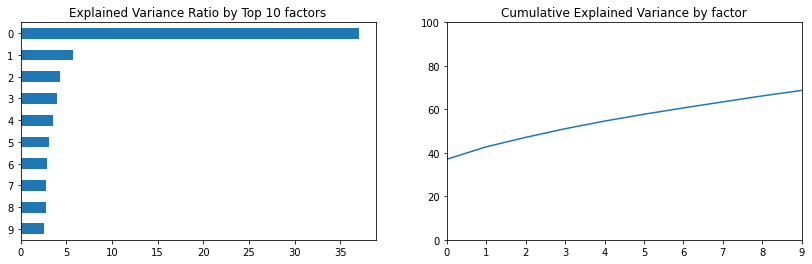

In [71]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

**Portfolio Weights**

In [72]:
def PCWeights():
    weights = pd.DataFrame()
    print(pca.components_[0])
    print(sum(pca.components_[0]))
    for i in range(len(pca.components_)):
      weights[i] = pca.components_[i] / sum(pca.components_[i])
    weights = weights.values.T
    return weights

weights=PCWeights()

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]
-5.247808242068631


In [73]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T
#.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=True, sharey=True, ylim= (-1,1))

,Portfolio 0,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4
MMM,0.043,0.083,-0.646,-0.083,0.800
AXP,0.044,-0.315,-0.036,-1.196,-1.098
AAPL,0.029,-1.149,0.263,1.173,0.290
BA,0.036,-0.043,-0.780,-0.504,1.030
CAT,0.038,-0.292,-1.338,-0.178,0.947
CVX,0.034,0.443,-2.483,0.876,0.305
CSCO,0.037,-1.235,0.593,0.906,-0.306
KO,0.032,0.849,0.634,0.604,0.872
DIS,0.040,-0.313,0.262,-0.232,-0.075
XOM,0.037,0.518,-2.259,1.012,0.306


**Sharpe Ratio**

In [74]:
# Sharpe Ratio
def sharpe_ratio(df, days_per_year=252):
    year = df.shape[0]/days_per_year

    annualized_return = np.power(np.prod(1+df),(1/year))-1

    annualized_vol = df.std() * np.sqrt(days_per_year)

    annualized_sharpe = annualized_return / annualized_vol

    return (annualized_return, annualized_vol, annualized_sharpe)

In [75]:
n_portfolios = len(pca.components_)
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
highest_sharpe = 0 
stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)
pcs = pca.components_
pc_w = pcs[0]/sum(pcs[0])
pc_w.squeeze()*100
eigen_port = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
eigen_port.sort_values(by=['weights'], ascending=False, inplace=True)
eigen_port_returns = np.dot(X_train_raw.loc[:, eigen_port.index], pc_w)
eigen_port_returns = pd.Series(eigen_port_returns.squeeze(), index=X_train_raw.index)
eigen_port_returns

Date
2000-01-11   -1.047e-03
2000-01-20   -7.567e-03
2000-02-02   -6.312e-03
2000-02-03   -4.304e-03
2000-02-04   -2.571e-03
                ...    
2015-08-13    3.552e-04
2015-08-14    3.247e-03
2015-08-17    3.702e-03
2015-08-18   -2.495e-03
2015-08-19   -9.461e-03
Length: 3113, dtype: float64

**Find Optimized Portfolio**

Eigen portfolio #0 with the highest Sharpe. Return 11.47%, vol = 13.31%, Sharpe = 0.86
    Return    Vol  Sharpe
0    0.115  0.133   0.862
7    0.096  0.693   0.138
5    0.100  0.845   0.118
1    0.057  0.670   0.084
2   -0.107  0.859  -0.124
11  -1.000  7.228  -0.138
13  -0.399  2.070  -0.193
25  -1.000  5.009  -0.200
23  -1.000  4.955  -0.202
6   -0.416  1.967  -0.212
10  -0.158  0.738  -0.213
3   -0.162  0.738  -0.220
26  -1.000  4.535  -0.220
8   -0.422  1.397  -0.302
17  -0.998  3.277  -0.305
24  -0.550  1.729  -0.318
16  -0.980  3.038  -0.323
21  -0.470  1.420  -0.331
14  -0.886  2.571  -0.345
27  -0.933  2.606  -0.358


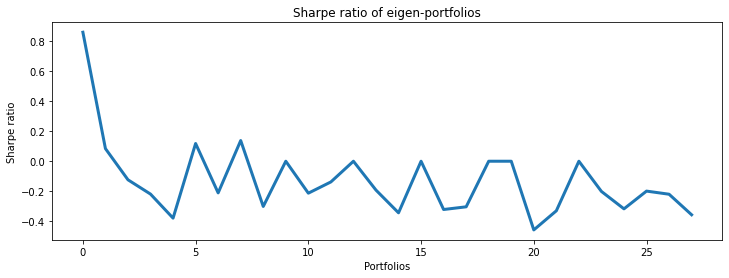

In [76]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        # each pc weights * 100, give stock code as index, and sort descending
        eigen_port = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_port.sort_values(by=['weights'], ascending=False, inplace=True)

        # X_train_raw = datareturns[:percentage]
        # sort stock returns based on its weight, dot each returns with its weight, give date as index
        eigen_port_returns = np.dot(X_train_raw.loc[:, eigen_port.index], pc_w)
        eigen_port_returns = pd.Series(eigen_port_returns.squeeze(), index=X_train_raw.index)

        er, vol, sharpe = sharpe_ratio(eigen_port_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric = np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()

**Current Eigen Portfolio Weights**

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]
-5.247808242068631
Sum of weights of current eigen-portfolio: 100.00


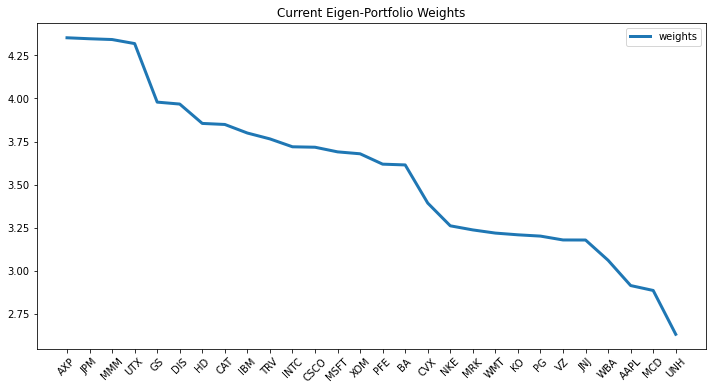

Sum of weights of current eigen-portfolio: 100.00


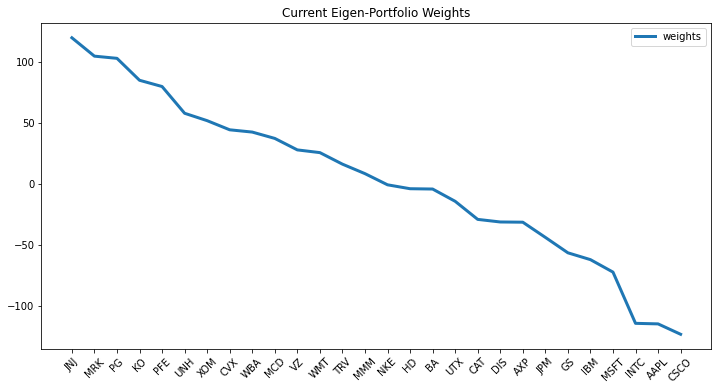

Sum of weights of current eigen-portfolio: 100.00


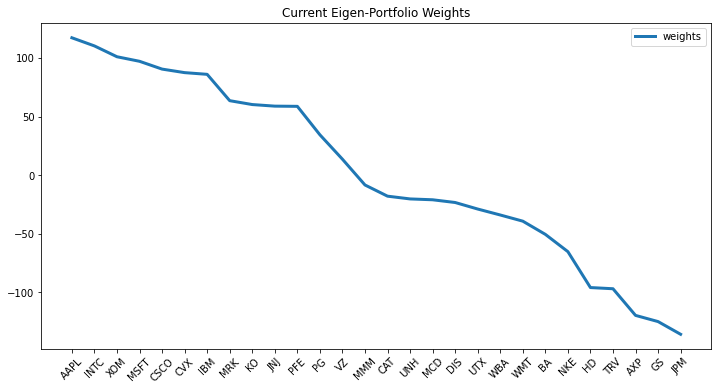

,weights
AAPL,117.347
INTC,110.392
XOM,101.153
MSFT,97.271
CSCO,90.615
CVX,87.599
IBM,86.145
MRK,63.667
KO,60.358
JNJ,59.004


In [77]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights[0], plot=True)
plotEigen(weights[1], plot=True)
plotEigen(weights[3], plot=True)

**Backtesting Eigen Portfolio**

Current Eigen-Portfolio 1:
Return = 99.80%
Volatility = 58.34%
Sharpe = 1.71


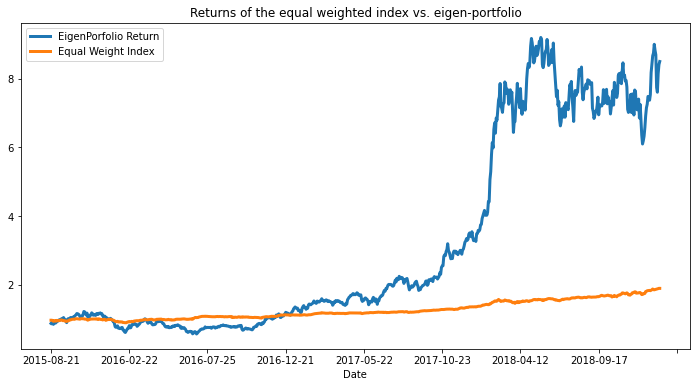

Current Eigen-Portfolio 5:
Return = 32.76%
Volatility = 68.64%
Sharpe = 0.48


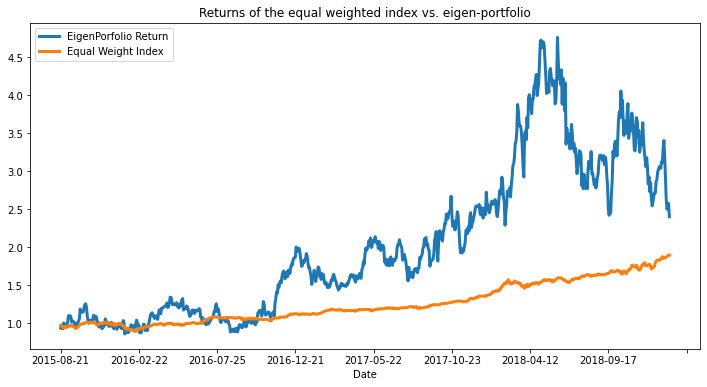

Current Eigen-Portfolio 2:
Return = -32.66%
Volatility = 76.12%
Sharpe = -0.43


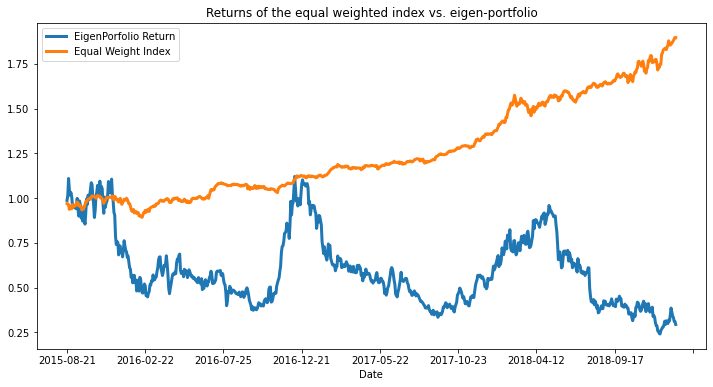

Current Eigen-Portfolio 14:
Return = -79.42%
Volatility = 185.30%
Sharpe = -0.43


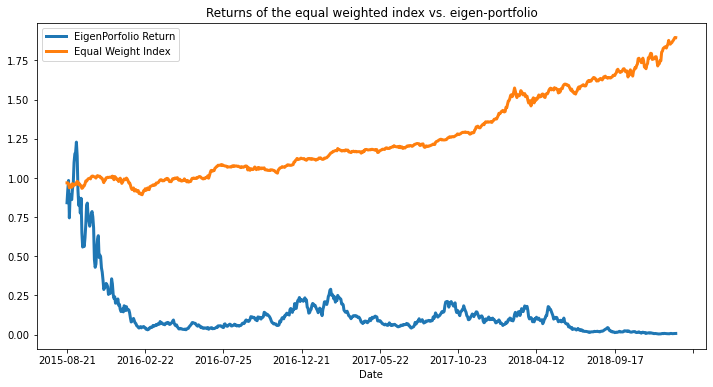

In [78]:
def Backtest(eigen, num):
    # Plots Principle components returns against real returns
    
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio %d:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (num, returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()
    
Backtest(weights[1], 1)
Backtest(weights[5], 5)
Backtest(weights[2], 2)
Backtest(weights[14], 14)